이전 스텝에서 배운 MF 모델 학습 방법을 토대로, 내가 좋아할 만한 영화 추천 시스템을 제작해 보겠습니다.

이번에 활용할 데이터셋은 추천 시스템의 MNIST라고 부를만한 Movielens 데이터입니다.

유저가 영화에 대해 평점을 매긴 데이터가 데이터 크기 별로 있습니다. MovieLens 1M Dataset 사용을 권장합니다.
별점 데이터는 대표적인 explicit 데이터입니다. 하지만 implicit 데이터로 간주하고 테스트해 볼 수 있습니다.
별점을 시청횟수로 해석해서 생각하겠습니다.
또한 유저가 3점 미만으로 준 데이터는 선호하지 않는다고 가정하고 제외하겠습니다.

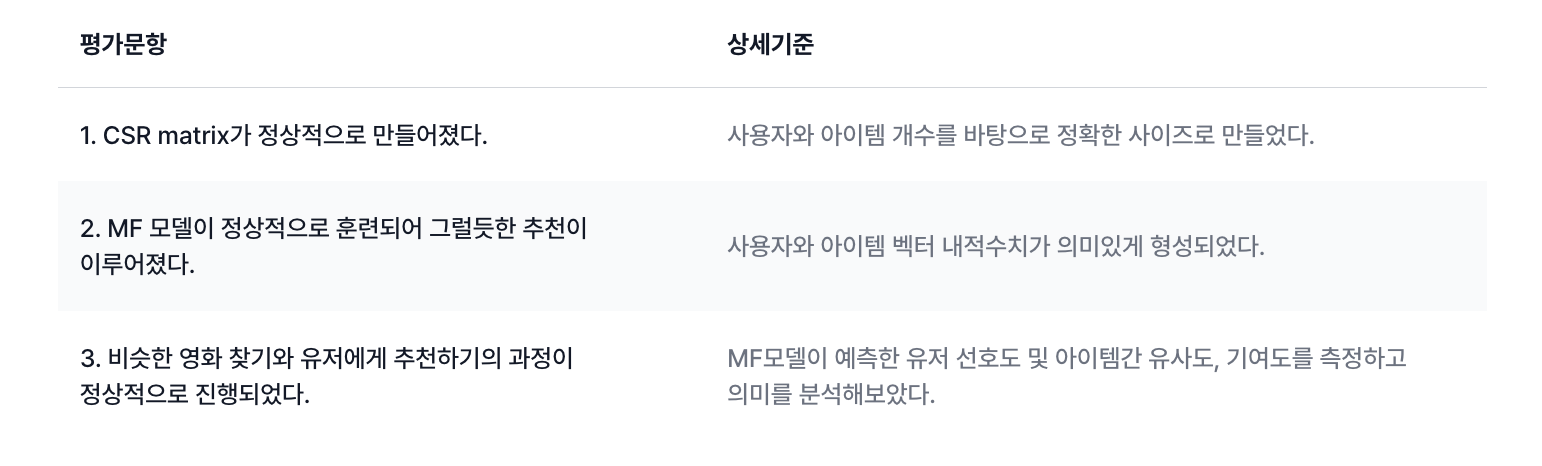

파일은 총 3개 : movies, ratings, users

## 1) 데이터 불러오기 & 전처리

In [1]:
import numpy as np
import scipy
import implicit

print(np.__version__)
print(scipy.__version__)
print(implicit.__version__)

1.21.4
1.7.1
0.4.8


In [2]:
import os
import pandas as pd

rating_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'ratings', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python', encoding = "ISO-8859-1")
orginal_data_size = len(ratings)
ratings.head()

,user_id,movie_id,ratings,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [3]:
# 3점 이상만 남깁니다.
ratings = ratings[ratings['ratings']>=3]
filtered_data_size = len(ratings)

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


In [4]:
# ratings 컬럼의 이름을 counts로 바꿉니다.
ratings.rename(columns={'ratings':'counts'}, inplace=True)

In [5]:
ratings.head()

,user_id,movie_id,counts,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [6]:
# 영화 제목을 보기 위해 메타 데이터를 읽어옵니다.
movie_file_path=os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/movies.dat'
cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')
movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
#소문자로 변경
movies['title'] = movies['title'].str.lower()

In [8]:
movies[movies.duplicated()]

,movie_id,title,genre


In [9]:
#import user information
user_file_path = os.getenv('HOME') + '/aiffel/recommendata_iu/data/ml-1m/users.dat'
cols = ['user_id', 'gender', 'age', 'occupation', 'zip-code']
users = pd.read_csv(user_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')
users.head()

,user_id,gender,age,occupation,zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [10]:
#각 표를 합쳐주도록 한다
movies_ratings = pd.merge(movies, ratings, on='movie_id')
movies_ratings.head()

,movie_id,title,genre,user_id,counts,timestamp
0,1,toy story (1995),Animation|Children's|Comedy,1,5,978824268
1,1,toy story (1995),Animation|Children's|Comedy,6,4,978237008
2,1,toy story (1995),Animation|Children's|Comedy,8,4,978233496
3,1,toy story (1995),Animation|Children's|Comedy,9,5,978225952
4,1,toy story (1995),Animation|Children's|Comedy,10,5,978226474


In [11]:
data = pd.merge(movies_ratings, users, on='user_id')
data.head()

,movie_id,title,genre,user_id,counts,timestamp,gender,age,occupation,zip-code
0,1,toy story (1995),Animation|Children's|Comedy,1,5,978824268,F,1,10,48067
1,48,pocahontas (1995),Animation|Children's|Musical|Romance,1,5,978824351,F,1,10,48067
2,150,apollo 13 (1995),Drama,1,5,978301777,F,1,10,48067
3,260,star wars: episode iv - a new hope (1977),Action|Adventure|Fantasy|Sci-Fi,1,4,978300760,F,1,10,48067
4,527,schindler's list (1993),Drama|War,1,5,978824195,F,1,10,48067



- genre를 | 기준으로 분리해주도록 한다 

In [13]:
# 'genre' 컬럼을 '|'를 기준으로 분리하고, expand=True로 각각의 분리된 값이 별도의 컬럼으로 오도록 설정
genres_split = data['genre'].str.split('|', expand=True)
data['genre_1'] = genres_split[0]
data['genre_2'] = genres_split[1]
data['genre_3'] = genres_split[2]
data['genre_4'] = genres_split[3]

data.head()

,movie_id,title,genre,user_id,counts,timestamp,gender,age,occupation,zip-code,genre_1,genre_2,genre_3,genre_4
0,1,toy story (1995),Animation|Children's|Comedy,1,5,978824268,F,1,10,48067,Animation,Children's,Comedy,None
1,48,pocahontas (1995),Animation|Children's|Musical|Romance,1,5,978824351,F,1,10,48067,Animation,Children's,Musical,Romance
2,150,apollo 13 (1995),Drama,1,5,978301777,F,1,10,48067,Drama,None,None,None
3,260,star wars: episode iv - a new hope (1977),Action|Adventure|Fantasy|Sci-Fi,1,4,978300760,F,1,10,48067,Action,Adventure,Fantasy,Sci-Fi
4,527,schindler's list (1993),Drama|War,1,5,978824195,F,1,10,48067,Drama,War,None,None


In [14]:
# 필요한 컬럼만 사용
data.drop(['genre', 'timestamp', 'zip-code'], axis=1, inplace=True)
data.head()

,movie_id,title,user_id,counts,gender,age,occupation,genre_1,genre_2,genre_3,genre_4
0,1,toy story (1995),1,5,F,1,10,Animation,Children's,Comedy,None
1,48,pocahontas (1995),1,5,F,1,10,Animation,Children's,Musical,Romance
2,150,apollo 13 (1995),1,5,F,1,10,Drama,None,None,None
3,260,star wars: episode iv - a new hope (1977),1,4,F,1,10,Action,Adventure,Fantasy,Sci-Fi
4,527,schindler's list (1993),1,5,F,1,10,Drama,War,None,None


In [15]:
# 영화 제목에서 연도도 분리
import pandas as pd

#괄호 안에 있는 숫자 4자리수를 추출한다
data['year'] = data['title'].str.extract('\((\d{4})\)')
data['title'] = data['title'].str.replace('\((\d{4})\)', '',  regex=True)
data['title'] = data['title'].str.strip()
data.head()

,movie_id,title,user_id,counts,gender,age,occupation,genre_1,genre_2,genre_3,genre_4,year
0,1,toy story,1,5,F,1,10,Animation,Children's,Comedy,None,1995
1,48,pocahontas,1,5,F,1,10,Animation,Children's,Musical,Romance,1995
2,150,apollo 13,1,5,F,1,10,Drama,None,None,None,1995
3,260,star wars: episode iv - a new hope,1,4,F,1,10,Action,Adventure,Fantasy,Sci-Fi,1977
4,527,schindler's list,1,5,F,1,10,Drama,War,None,None,1993


In [16]:
# 첫 번째 사용자의 데이터를 예로 들면,
user_1 = data[data['user_id'] == 1][['title', 'year', 'genre_1', 'genre_2', 'genre_3', 'genre_4']]

# 장르 컬럼들을 하나의 열로 표현
melted_genres = user_1.melt(id_vars=['title', 'year'], value_vars=['genre_1', 'genre_2', 'genre_3', 'genre_4'], value_name='genre')
melted_genres.head()

,title,year,variable,genre
0,toy story,1995,genre_1,Animation
1,pocahontas,1995,genre_1,Animation
2,apollo 13,1995,genre_1,Drama
3,star wars: episode iv - a new hope,1977,genre_1,Action
4,schindler's list,1993,genre_1,Drama


In [17]:
melted_genres[melted_genres['title']=='pocahontas']

,title,year,variable,genre
1,pocahontas,1995,genre_1,Animation
54,pocahontas,1995,genre_2,Children's
107,pocahontas,1995,genre_3,Musical
160,pocahontas,1995,genre_4,Romance


In [18]:
# NaN 값 제거
melted_genres = melted_genres.dropna(subset=['genre'])

# 가장 많이 등장하는 장르 계산
favorite_genre = melted_genres['genre'].value_counts().idxmax()
melted_genres['genre'].value_counts()

Drama         21
Children's    20
Animation     18
Comedy        14
Musical       13
Romance        6
Action         5
Adventure      5
Thriller       3
Sci-Fi         3
Fantasy        3
Crime          2
War            2
Name: genre, dtype: int64

- user1 이 가장 많이 본 장르를 알 수 있다

## 2) 데이터 분석

In [19]:
#ratings에 있는 유니크한 영화 개수
data['movie_id'].nunique()

3628

In [20]:
#ratings에 있는 유니크한 사용자 수
data['user_id'].nunique()

6039

In [21]:
#가장 인기있는 영화 30개 (인기순)
movie_count = data.groupby('title')['user_id'].count()
movie_count.sort_values(ascending=False).head(30)

title
american beauty                                   3211
star wars: episode iv - a new hope                2910
star wars: episode v - the empire strikes back    2885
star wars: episode vi - return of the jedi        2716
saving private ryan                               2561
terminator 2: judgment day                        2509
silence of the lambs, the                         2498
raiders of the lost ark                           2473
back to the future                                2460
matrix, the                                       2434
jurassic park                                     2413
sixth sense, the                                  2385
fargo                                             2371
braveheart                                        2314
men in black                                      2297
schindler's list                                  2257
princess bride, the                               2252
shakespeare in love                               2213
l.a.

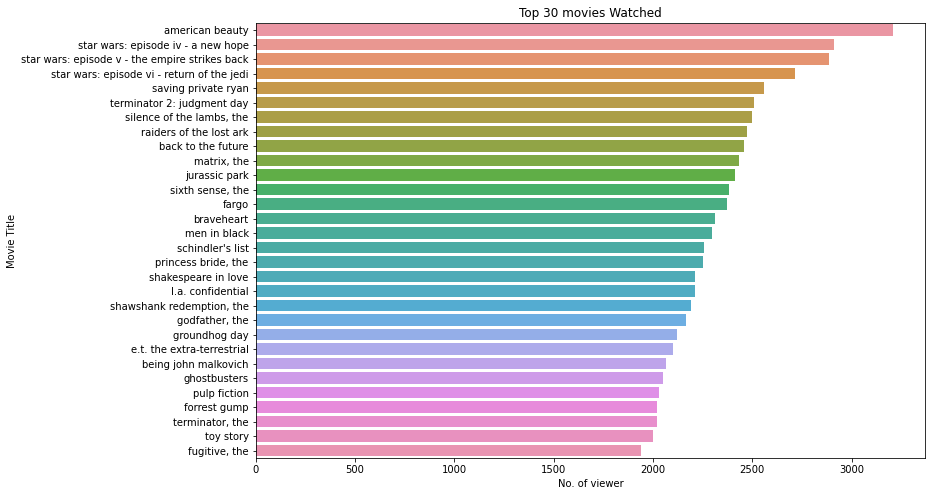

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

top_30 = data.groupby('title')['user_id'].count().sort_values(ascending=False).head(30)

plt.figure(figsize=(12,8))
sns.barplot(x=top_30.values, y=top_30.index)

plt.title('Top 30 movies Watched')
plt.xlabel('No. of viewer')
plt.ylabel('Movie Title')
plt.show()

In [23]:
#각각의 유저가 몇 개의 영화를 보는지 통계값
user_count = data.groupby('user_id')['title'].count()
user_count.describe()

count    6039.000000
mean      138.512668
std       156.241599
min         1.000000
25%        38.000000
50%        81.000000
75%       177.000000
max      1968.000000
Name: title, dtype: float64

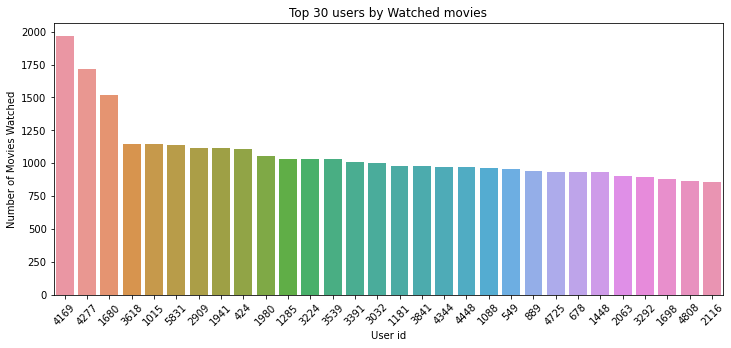

In [24]:
#제일 영화 많이 본 사람
user_30 = data.groupby('user_id')['title'].count().sort_values(ascending=False).head(30)

plt.figure(figsize=(12,5))
sns.barplot(x=user_30.index, y=user_30.values,order=user_30.index)

plt.title('Top 30 users by Watched movies')
plt.xlabel('User id')
plt.ylabel('Number of Movies Watched')
plt.xticks(rotation=45)
plt.show()

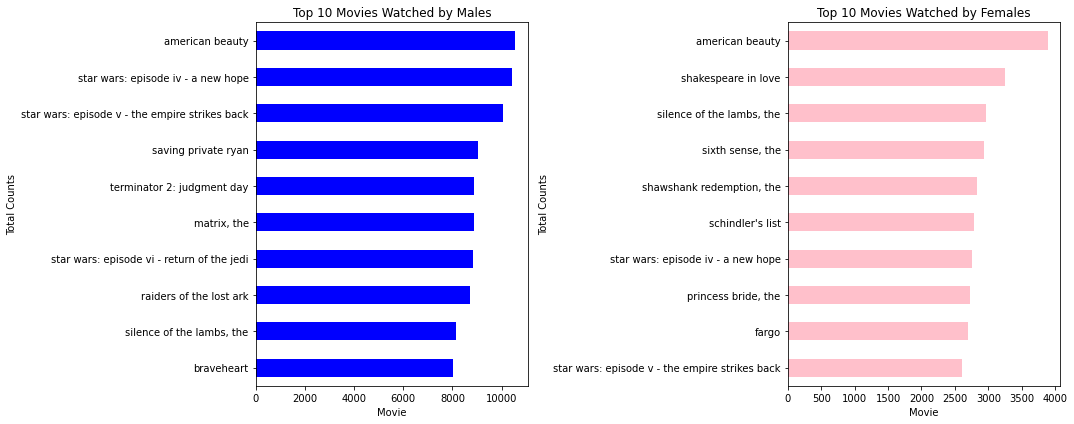

In [60]:
#성별로 가장 많이 본 10개의 영화 계산

# 각 영화의 총 시청 횟수 계산
total_counts = data.groupby('title')['counts'].sum()

# 성별에 따라 영화 그룹화
male_movies = data[data['gender'] == 'M'].groupby('title')['counts'].sum().nlargest(10).sort_values(ascending=True)
female_movies = data[data['gender'] == 'F'].groupby('title')['counts'].sum().nlargest(10).sort_values(ascending=True)

# 그래프 그리기
plt.figure(figsize=(15, 6))

# 남성이 가장 많이 본 영화
plt.subplot(1, 2, 1)
male_movies.plot(kind='barh', color='blue')
plt.title('Top 10 Movies Watched by Males')
plt.xlabel('Movie')
plt.ylabel('Total Counts')

# 여성이 가장 많이 본 영화
plt.subplot(1, 2, 2)
female_movies.plot(kind='barh', color='pink')
plt.title('Top 10 Movies Watched by Females')
plt.xlabel('Movie')
plt.ylabel('Total Counts')

plt.tight_layout()
plt.show()

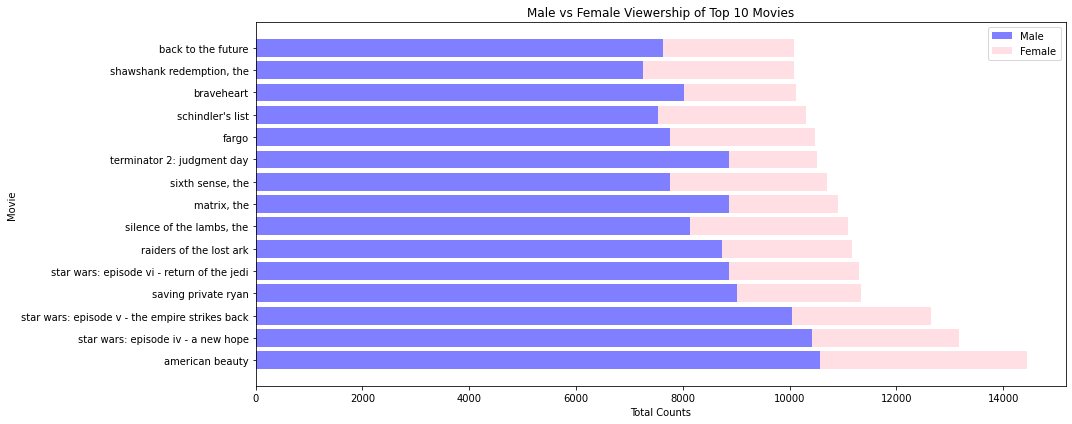

In [73]:
# 각 영화의 총 시청 횟수 계산
total_counts = data.groupby('title')['counts'].sum()

# 전체에서 가장 많이 본 영화 16개 선택
top_movies = total_counts.nlargest(15)

# 각 영화별 남자와 여자의 시청 횟수 계산
male_counts = data[data['gender'] == 'M'].groupby('title')['counts'].sum()
female_counts = data[data['gender'] == 'F'].groupby('title')['counts'].sum()

# 그래프 그리기
plt.figure(figsize=(15, 6))
  
# 각 영화별 남성과 여성의 시청 비율 그리기
for i, movie_title in enumerate(top_movies.index):
    total_counts = top_movies[movie_title]
    male_count = male_counts.get(movie_title, 0)
    female_count = female_counts.get(movie_title, 0)
    plt.barh(movie_title, male_count, color='blue', alpha=0.5, label='Male' if i == 0 else None)
    plt.barh(movie_title, female_count, left=male_count, color='pink', alpha=0.5, label='Female' if i == 0 else None)

# 전체 시청 횟수에 대한 범례 추가
plt.legend(['Male', 'Female'])

plt.xlabel('Total Counts')
plt.ylabel('Movie')
plt.title('Male vs Female Viewership of Top 10 Movies')
plt.tight_layout()
plt.show()

- 남자가 영화를 더 많이 본다고 나온다

## 3) 내가 좋아하는 영화 5개 추가

In [25]:
my_favorite = ['fargo', 'dumbo', 'american psycho', 'chinatown', 'titanic']

In [26]:
# 영화 제목이 중복되지 않도록 drop_duplicates를 사용하여 첫 번째 값을 유지합니다.
movie_info_df = data.drop_duplicates(subset='title')[['movie_id', 'title', 'genre_1', 'genre_2', 'genre_3', 'genre_4', 'year']]

# 영화 제목을 key로 하고 다른 컬럼들을 value로 하는 사전 생성
movie_dict = movie_info_df.set_index('title').to_dict('index')

# 새로운 유저 데이터프레임을 생성합니다.
my_movies = pd.DataFrame({
    'user_id': [6040]*5,
    'title': my_favorite,  # 영화 제목 리스트
    'counts':[5]*5,
    'gender': ['F']*5,
    'age': [30.0]*5,
    'occupation': [0]*5
})

# my_movies에 영화 정보를 채워넣기 위한 과정
for i, row in my_movies.iterrows():
    title = row['title']
    movie_info = movie_dict.get(title)
    if movie_info:
        my_movies.at[i, 'movie_id'] = movie_info['movie_id']
        my_movies.at[i, 'genre_1'] = movie_info.get('genre_1')
        my_movies.at[i, 'genre_2'] = movie_info.get('genre_2')
        my_movies.at[i, 'genre_3'] = movie_info.get('genre_3')
        my_movies.at[i, 'genre_4'] = movie_info.get('genre_4')
        my_movies.at[i, 'year'] = movie_info.get('year')

# 마지막으로 my_movies 데이터프레임을 원본 data에 추가합니다.
data = pd.concat([data, my_movies], ignore_index=True)

# 결과 확인
data.tail(10)

,movie_id,title,user_id,counts,gender,age,occupation,genre_1,genre_2,genre_3,genre_4,year
836473,3785.0,scary movie,3043,3,M,18.0,2,Comedy,Horror,None,None,2000
836474,3786.0,but i'm a cheerleader,3043,3,M,18.0,2,Comedy,None,None,None,1999
836475,3852.0,"tao of steve, the",3043,5,M,18.0,2,Comedy,None,None,None,2000
836476,3882.0,bring it on,3043,5,M,18.0,2,Comedy,None,None,None,2000
836477,3897.0,almost famous,3043,5,M,18.0,2,Comedy,Drama,None,None,2000
836478,608.0,fargo,6040,5,F,30.0,0,Crime,Drama,Thriller,NaN,1996
836479,1029.0,dumbo,6040,5,F,30.0,0,Animation,Children's,Musical,NaN,1941
836480,3535.0,american psycho,6040,5,F,30.0,0,Comedy,Horror,Thriller,NaN,2000
836481,1252.0,chinatown,6040,5,F,30.0,0,Film-Noir,Mystery,Thriller,NaN,1974
836482,1721.0,titanic,6040,5,F,30.0,0,Drama,Romance,None,NaN,1997


In [27]:
data = data.where(pd.notnull(data), None)
data.tail(10)

,movie_id,title,user_id,counts,gender,age,occupation,genre_1,genre_2,genre_3,genre_4,year
836473,3785.0,scary movie,3043,3,M,18.0,2,Comedy,Horror,None,None,2000
836474,3786.0,but i'm a cheerleader,3043,3,M,18.0,2,Comedy,None,None,None,1999
836475,3852.0,"tao of steve, the",3043,5,M,18.0,2,Comedy,None,None,None,2000
836476,3882.0,bring it on,3043,5,M,18.0,2,Comedy,None,None,None,2000
836477,3897.0,almost famous,3043,5,M,18.0,2,Comedy,Drama,None,None,2000
836478,608.0,fargo,6040,5,F,30.0,0,Crime,Drama,Thriller,None,1996
836479,1029.0,dumbo,6040,5,F,30.0,0,Animation,Children's,Musical,None,1941
836480,3535.0,american psycho,6040,5,F,30.0,0,Comedy,Horror,Thriller,None,2000
836481,1252.0,chinatown,6040,5,F,30.0,0,Film-Noir,Mystery,Thriller,None,1974
836482,1721.0,titanic,6040,5,F,30.0,0,Drama,Romance,None,None,1997


In [28]:
data['movie_id'] = data['movie_id'].astype('Int64')
data['age'] = data['age'].astype('Int64')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 836483 entries, 0 to 836482
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   movie_id    836483 non-null  Int64 
 1   title       836483 non-null  object
 2   user_id     836483 non-null  int64 
 3   counts      836483 non-null  int64 
 4   gender      836483 non-null  object
 5   age         836483 non-null  Int64 
 6   occupation  836483 non-null  int64 
 7   genre_1     836483 non-null  object
 8   genre_2     576698 non-null  object
 9   genre_3     254940 non-null  object
 10  genre_4     78184 non-null   object
 11  year        836483 non-null  object
dtypes: Int64(2), int64(3), object(7)
memory usage: 78.2+ MB


## 4) MF모델 만들기

In [29]:
from scipy.sparse import csr_matrix

num_user= data['user_id'].max()+1
num_movie = data['movie_id'].max()+1

csr_data=  csr_matrix((data['counts'], (data.user_id, data.movie_id)), shape=(num_user, num_movie))
csr_data

<6041x3953 sparse matrix of type '<class 'numpy.int64'>'
	with 836481 stored elements in Compressed Sparse Row format>

- user_id와 movie_id가 연속적이며 누락된 값 없이 0부터 시작하므로, max() + 1을 사용하여 CSR Matrix의 shape을 결정하는 것이 적절함

## 5)  als_model = AlternatingLeastSquares 모델 구성하여 훈련

In [30]:
#학습
from implicit.als import AlternatingLeastSquares
import os
import numpy as np

# implicit 라이브러리에서 권장하고 있는 부분입니다. 학습 내용과는 무관합니다.
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

In [31]:
# Implicit AlternatingLeastSquares 모델의 선언
als_model = AlternatingLeastSquares(factors=100, regularization=0.01, use_gpu=False, iterations=15, dtype=np.float32)

In [32]:
# als 모델은 input으로 (item X user 꼴의 matrix를 받기 때문에 Transpose해줍니다.)
csr_data_transpose = csr_data.T
csr_data_transpose

<3953x6041 sparse matrix of type '<class 'numpy.int64'>'
	with 836481 stored elements in Compressed Sparse Column format>

In [33]:
# 모델 훈련
als_model.fit(csr_data_transpose)

  0%|          | 0/15 [00:00<?, ?it/s]

In [34]:
user_id_6040 = 6040  # 예제 유저 ID
movie_id_chinatown = data[data['title'] == 'chinatown']['movie_id'].iloc[0]  # 'Chinatown' 영화의 movie_id

user_vector_6040 = als_model.user_factors[user_id_6040]
movie_vector_chinatown = als_model.item_factors[movie_id_chinatown]
preference_score = np.dot(user_vector_6040, movie_vector_chinatown)

In [35]:
user_vector_6040

array([ 2.5755942 ,  3.1820948 ,  5.374908  , -2.7446177 , -1.9144728 ,
        2.332145  , -2.4272163 , -2.8087811 ,  3.4286916 , -0.18499951,
       -3.6799698 ,  3.281166  , -0.33465484,  2.7356298 , -4.9429116 ,
       -0.21918297,  0.18847543,  1.2843163 ,  3.904836  ,  2.2020772 ,
        1.2484425 , -0.1426834 , -1.2249691 ,  3.796232  ,  0.21008687,
       -0.53786826, -2.3539903 , -0.53756297,  0.93305266,  0.9546869 ,
        2.0037618 ,  2.4311004 ,  1.3309937 ,  3.4345183 ,  2.1541157 ,
        1.0212415 , -0.06885806, -2.1053088 ,  2.3719065 , -0.25976115,
        0.5723149 , -2.1691847 ,  0.43041822,  1.3495766 ,  2.6660535 ,
        0.53412217, -0.1581486 ,  0.28025967,  3.663323  ,  1.0218679 ,
        0.38212729,  2.7576673 ,  2.5955565 , -3.7611656 ,  3.072685  ,
       -3.0274167 , -4.861058  , -1.0844245 , -0.39944327, -1.7497034 ,
       -0.5809232 ,  2.1766124 ,  0.6620038 , -2.1403942 , -0.6776904 ,
       -3.6797464 ,  3.0756052 , -2.1660314 , -0.64243656, -1.38

In [38]:
movie_vector_chinatown

array([ 3.57733741e-02,  1.30332941e-02,  3.15636322e-02, -3.75792980e-02,
       -9.81893507e-04,  2.94876983e-03,  1.91408396e-02,  3.16818096e-02,
        2.42404751e-02, -1.04183741e-02,  1.76489260e-02,  1.52287688e-02,
       -1.21232681e-02,  1.15542356e-02, -1.23717617e-02,  7.96761084e-03,
        2.88007478e-03,  5.45130437e-03,  4.42521693e-03,  9.01404489e-03,
       -2.43212283e-02,  1.31063210e-02,  1.22948559e-02,  4.98246448e-03,
        1.06809177e-02,  1.14537263e-02,  1.24367559e-02,  6.17557298e-03,
        5.67039335e-03, -1.25279780e-02,  1.03335334e-02,  2.15412099e-02,
       -1.41994804e-02, -1.85472444e-02, -1.32691991e-02, -1.61381178e-02,
        1.72067701e-03,  1.38083776e-03,  1.16677275e-02,  2.27805898e-02,
       -1.58521254e-03,  1.86121911e-02,  3.80898500e-03, -8.80165026e-03,
       -5.78686455e-03, -4.52064769e-03, -2.94957217e-02, -1.61417574e-02,
        4.97502051e-02, -7.96769280e-03,  1.07421512e-02,  2.39554811e-02,
        2.40266938e-02,  

In [37]:
preference_score

0.8991886

## 6) 내가 선호하는 5가지 영화 중 하나와 그 외의 영화 하나를 골라 훈련된 모델이 예측한 나의 선호도를 파악해 보세요.

american psycho 를 가지고 해보자

In [41]:
data[data['title'] == 'american psycho']

,movie_id,title,user_id,counts,gender,age,occupation,genre_1,genre_2,genre_3,genre_4,year
8677,3535,american psycho,149,3,M,25,1,Comedy,Horror,Thriller,None,2000
9617,3535,american psycho,162,3,F,18,4,Comedy,Horror,Thriller,None,2000
10275,3535,american psycho,169,3,M,25,7,Comedy,Horror,Thriller,None,2000
10759,3535,american psycho,173,4,M,25,0,Comedy,Horror,Thriller,None,2000
15181,3535,american psycho,225,3,M,25,7,Comedy,Horror,Thriller,None,2000
...,...,...,...,...,...,...,...,...,...,...,...,...
835898,3535,american psycho,3245,5,M,18,2,Comedy,Horror,Thriller,None,2000
836129,3535,american psycho,1270,3,M,25,6,Comedy,Horror,Thriller,None,2000
836422,3535,american psycho,5380,5,M,18,4,Comedy,Horror,Thriller,None,2000
836444,3535,american psycho,2245,4,M,1,10,Comedy,Horror,Thriller,None,2000


- 장르는 comedy, horror, thriller이다

In [44]:
# american beauty
movie_id_american = data[data['title'] == 'american beauty']['movie_id'].iloc[0]  # 'Chinatown' 영화의 movie_id
movie_vector_american = als_model.item_factors[movie_id_american]
np.dot(user_vector_6040, movie_vector_american)

1.089698

In [45]:
#apollo 13
movie_id_apollo = data[data['title'] == 'apollo 13']['movie_id'].iloc[0]
movie_vector_apollo = als_model.item_factors[movie_id_apollo]
np.dot(user_vector_6040, movie_vector_apollo)

0.63358176

In [46]:
# sister act
movie_id_sister = data[data['title'] == 'sister act']['movie_id'].iloc[0] 
movie_vector_sister = als_model.item_factors[movie_id_sister]
np.dot(user_vector_6040, movie_vector_sister)

0.038404137

## 7) 내가 좋아하는 영화와 비슷한 영화를 추천받아 봅시다.

In [47]:
favorite_movie = 'american psycho'
# 'Chinatown' 영화의 movie_id 찾기
movie_id = data[data['title'] == favorite_movie]['movie_id'].iloc[0]

# 비슷한 영화 찾기
similar_movies = als_model.similar_items(movie_id, N=15)
similar_movies

[(3535, 1.0),
 (3409, 0.5849239),
 (3566, 0.5283436),
 (3515, 0.5091032),
 (3160, 0.5051183),
 (3173, 0.5033279),
 (3863, 0.5011997),
 (3553, 0.4931571),
 (3509, 0.47966883),
 (3484, 0.46851704),
 (3150, 0.4660312),
 (3896, 0.44723085),
 (3596, 0.44614366),
 (3617, 0.44212303),
 (3949, 0.42973366)]

In [49]:
# 유사한 영화의 id를 기반으로 영화 제목 가져오기
similar_movie_ids = [movie_id for movie_id, _ in similar_movies]
similar_movie_titles = data[data['movie_id'].isin(similar_movie_ids)]['title'].unique()

# 결과 출력
print("Similar to 'American Psycho':")
for title in similar_movie_titles:
    print(title)

Similar to 'American Psycho':
magnolia
screwed
cell, the
any given sunday
final destination
skulls, the
gossip
road trip
requiem for a dream
way of the gun, the
american psycho
me myself i
big kahuna, the
black and white
war zone, the


## 8) 내가 가장 좋아할 만한 영화들을 추천받아 봅시다.

In [53]:
# 'chinatown' 영화의 movie_id 찾기
favorite_movie = 'american psycho'
movie_id = data[data['title'] == favorite_movie]['movie_id'].iloc[0]

# 사용자 6040의 'Chinatown' 추천에 대한 기여도 분석
user_id = 6040
explain = als_model.explain(user_id, csr_data, itemid=movie_id)

# 기여도가 높은 아이템들과 그 기여도 점수 추출
contributions = [(data[data['movie_id'] == idx]['title'].iloc[0], score) for idx, score in explain[1]]

# 결과 출력
print(f"Contribution to '{favorite_movie}' recommendation for user {user_id}:")
for title, score in contributions:
    print(f"{title}: {score:.4f}")

Contribution to 'american psycho' recommendation for user 6040:
american psycho: 0.2355
welcome to the dollhouse: 0.0298
run lola run (lola rennt): 0.0282
annie hall: 0.0276
l.a. confidential: 0.0269
killing fields, the: 0.0267
one flew over the cuckoo's nest: 0.0254
all about my mother (todo sobre mi madre): 0.0253
ice storm, the: 0.0248
when harry met sally...: 0.0247


## 회고
- 추천시스템 너무 재미있는데 더 공부해보고 싶습니다
